_Last updated: Alba, 12 December 2025._  
For questions or issues, please contact **aricoro@clemson.edu**.


# Inverse Compton Scattering

This notebook implements inverse Compton scattering from first principles, following the formalism of *Rybicki & Lightman, Radiative Processes in Astrophysics*. 
For the full theoretical background and derivations, please refer to the accompanying **GitHub Wiki**.




### Setup and Physical Constants


In [59]:

import numpy as np
import math
import matplotlib.pyplot as plt

# Physical constants (SI)
h = 6.62607015e-34       # Planck (J s)
c = 2.99792458e8         # speed of light (m/s)
me = 9.10938356e-31      # electron mass (kg)
me_c2 = me * c**2        # electron rest energy (J)


### Lorentz Boost (Lab → Electron Rest Frame)

We consider an electron moving along the +z direction with velocity βc. All transformations between the laboratory frame and the electron rest frame (ERF) are performed using the Lorentz boost matrix along the z axis.

In this notebook, we implement utility functions to:
- convert between β and the Lorentz factor γ,
- construct the Lorentz boost matrix,
- and apply the boost to arbitrary four-vectors.

The detailed derivation and matrix form are provided in the Wiki.


In [60]:

def gamma_from_beta(beta: float) -> float:
    beta = np.clip(beta, 0.0, 1.0 - 1e-15)
    return 1.0 / np.sqrt(1.0 - beta**2)

def beta_from_gamma(gamma: float) -> float:
    gamma = max(gamma, 1.0)
    return np.sqrt(1.0 - 1.0/gamma**2)

def boost_matrix_z(beta: float) -> np.ndarray:
    g = gamma_from_beta(beta)
    return np.array([[ g, 0.0, 0.0, -g*beta],
                     [0.0, 1.0, 0.0,  0.0   ],
                     [0.0, 0.0, 1.0,  0.0   ],
                     [-g*beta, 0.0, 0.0, g  ]], dtype=float)

def apply_boost_z(fourvec: np.ndarray, beta: float) -> np.ndarray:
    # Return Lambda(beta) times fourvec
    return boost_matrix_z(beta) @ fourvec


### Doppler Shift and Aberration

Photon energies and directions are transformed from the laboratory frame to the ERF by applying the Lorentz boost to the photon four-momentum.

This yields the Doppler-shifted photon energy and the aberration of the propagation direction in the ERF. These transformations determine the kinematic input for the scattering calculation and are derived explicitly in the Wiki.


In [61]:

def doppler_to_erf(epsilon_lab_J: float, cos_theta: float, beta: float) -> float:
    # epsilon' = gamma * epsilon * (1 - beta * cos(theta))
    g = gamma_from_beta(beta)
    return g * epsilon_lab_J * (1.0 - beta * cos_theta)

def aberration_lab_to_erf(cos_theta: float, beta: float) -> float:
    # cos(theta') = (cos(theta) - beta) / (1 - beta * cos(theta))
    num = cos_theta - beta
    den = 1.0 - beta * cos_theta
    return np.clip(num/den, -1.0, 1.0)


### Compton Scattering in the Electron Rest Frame

In the electron rest frame, the scattered photon energy is determined by energy–momentum conservation. The calculation can be performed using either:
- the full Klein–Nishina expression, valid at all energies, or
- the Thomson approximation, applicable when the photon energy is much smaller than the electron rest mass.

Both options are implemented below and can be selected depending on the physical regime of interest.


In [62]:

def epsilon_s_erf_kn(eps_in_prime_J: float, cos_Theta_prime: np.ndarray) -> np.ndarray:
    # Klein-Nishina: eps_out' = eps_in' / [1 + (eps_in' / (m_e c^2)) * (1 - cos Theta')]
    x = eps_in_prime_J / me_c2
    return eps_in_prime_J / (1.0 + x * (1.0 - cos_Theta_prime))

def epsilon_s_erf_thomson(eps_in_prime_J: float, shape_like: np.ndarray) -> np.ndarray:
    # Thomson: elastic in ERF; broadcast to match angle array.
    return np.full_like(shape_like, eps_in_prime_J, dtype=float)


### Scattering Geometry in the ERF

After scattering, the photon direction in the ERF must be related to the original boost axis. The outgoing polar angle is obtained from simple spherical geometry, given the incoming ERF angle and the scattering deflection angle.

This geometric step provides the ERF direction needed for the final boost back to the laboratory frame.


In [63]:

def cos_theta_out_erf(cos_theta_in_prime: float, cos_Theta_prime: np.ndarray) -> np.ndarray:
    # cos(theta_s') = cos(theta_in') * cos(Theta') + sin(theta_in') * sin(Theta')
    theta_in = np.arccos(np.clip(cos_theta_in_prime, -1, 1))
    sin_theta_in = np.sin(theta_in)
    sin_Theta = np.sqrt(1.0 - np.clip(cos_Theta_prime, -1, 1)**2)
    return (cos_theta_in_prime * cos_Theta_prime + sin_theta_in * sin_Theta)


### Boost Back to the Laboratory Frame

Once the photon has scattered in the ERF, its energy and direction are transformed back to the laboratory frame using the inverse Lorentz boost.

This step produces the observed photon energy and scattering angle in the laboratory frame and introduces relativistic beaming and energy amplification.


In [64]:

def doppler_to_lab(epsilon_prime_J: np.ndarray, cos_theta_prime_out: np.ndarray, beta: float) -> np.ndarray:
    # epsilon = gamma * epsilon' * (1 + beta * cos(theta'))
    g = gamma_from_beta(beta)
    return g * epsilon_prime_J * (1.0 + beta * cos_theta_prime_out)

def aberration_erf_to_lab(cos_theta_prime_out: np.ndarray, beta: float) -> np.ndarray:
    # cos(theta) = (cos(theta') + beta) / (1 + beta * cos(theta'))
    num = cos_theta_prime_out + beta
    den = 1.0 + beta * cos_theta_prime_out
    return np.clip(num/den, -1.0, 1.0)


### Frequency Gain vs. Scattering Angle

Combining the Lorentz transformations and the ERF scattering calculation allows us to compute the frequency gain,
$\tilde{\nu}/\nu$, as a function of the laboratory scattering angle.

The following plots illustrate how inverse Compton scattering preferentially boosts photons in the forward direction and how the gain depends on the scattering geometry and the electron Lorentz factor.


In [65]:
# These are plotting settings

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # Figure size + DPI
    "figure.figsize": (10, 6),
    "figure.dpi": 120,

    # Fonts
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",

    # Titles & labels
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "axes.linewidth": 1.2,

    # Tick labels
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",

    # Lines (NO MARKERS)
    "lines.linewidth": 2.5,
    "lines.markersize": 0,
    "lines.marker": "",          
    "lines.markeredgewidth": 0,

    # Legend
    "legend.fontsize": 14,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.borderaxespad": 1.0,

    # Grid
    "axes.grid": True,
    "grid.linewidth": 0.6,
    "grid.alpha": 0.4,
})


**Figure 1**: The frequency gain peaks at small laboratory scattering angles and decreases rapidly with increasing angle. This reflects relativistic Doppler boosting and forward beaming: photons scattered near the electron direction receive the largest energy boost.


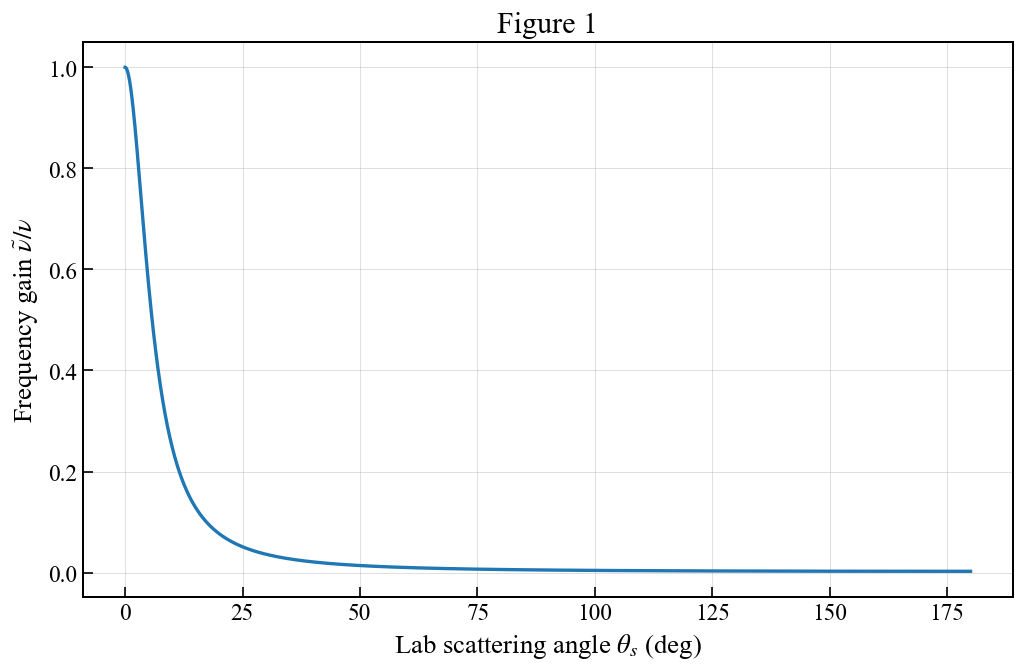

In [66]:

def ics_gain_vs_theta_lab(gamma: float, nu_in_hz: float, theta_in_deg: float,
                          use_klein_nishina: bool = True, n_angles: int = 361):
    beta = beta_from_gamma(gamma)
    eps_lab = h * nu_in_hz
    cos_theta_lab = math.cos(math.radians(theta_in_deg))

    # Lab → ERF
    eps_prime = doppler_to_erf(eps_lab, cos_theta_lab, beta)
    cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab, beta)

    # Sweep ERF scattering angle Theta'
    Theta_prime = np.linspace(0.0, np.pi, n_angles)
    cos_Theta_prime = np.cos(Theta_prime)

    # Outgoing ERF direction relative to +z
    cos_theta_prime_out = cos_theta_out_erf(cos_theta_prime_in, cos_Theta_prime)

    # ERF scattered energy
    if use_klein_nishina:
        eps_prime_out = epsilon_s_erf_kn(eps_prime, cos_Theta_prime)
    else:
        eps_prime_out = epsilon_s_erf_thomson(eps_prime, cos_Theta_prime)

    # ERF → Lab
    eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
    nu_out = eps_out / h

    # Outgoing lab angle
    cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
    theta_lab_out = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1, 1)))

    gain = nu_out / nu_in_hz
    return theta_lab_out, gain

# Demo plot
theta_s, gain = ics_gain_vs_theta_lab(gamma=10.0, nu_in_hz=1e14, theta_in_deg=0.0, use_klein_nishina=True)
plt.figure()
plt.plot(theta_s, gain, lw=2)
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.title('Figure 1')
plt.grid(True); plt.show()


**Figure 2**: Higher-$\gamma$ electrons produce stronger forward beaming: the frequency gain peaks sharply near $\theta_s\!\approx\!0^\circ$ and falls off rapidly with angle.


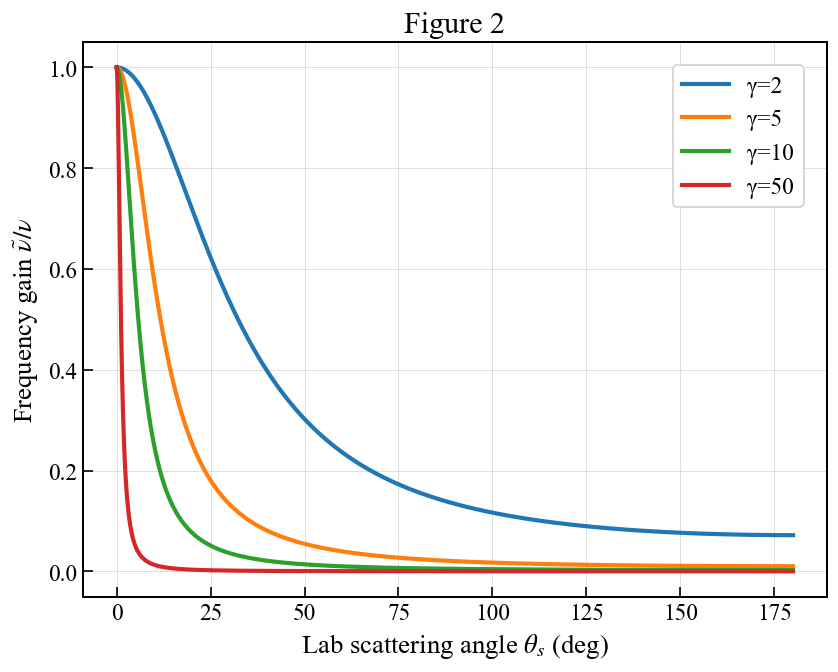

In [67]:
gammas = [2, 5, 10, 50]
nu_in = 1e14
theta_in = 0.0
plt.figure(figsize=(8,6))

for g in gammas:
    theta_s, gain =  ics_gain_vs_theta_lab(g, nu_in, theta_in, use_klein_nishina=True)
    plt.plot(theta_s, gain, label=f"γ={g}")

plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.legend()
plt.title('Figure 2')
plt.grid(True)
plt.show()


**Figure 3:** Maximum scattered photon energy as a function of the incident photon angle in the laboratory frame. The energy decreases monotonically with increasing $\theta_{\rm in}$, reflecting the reduction in Doppler boosting as the photon direction becomes more aligned with the electron velocity. Photons incident head-on ($\theta_{\rm in}\!\approx\!180^\circ$) receive the largest energy boost, while photons propagating along the electron direction ($\theta_{\rm in}\!\approx\!0^\circ$) gain little energy.




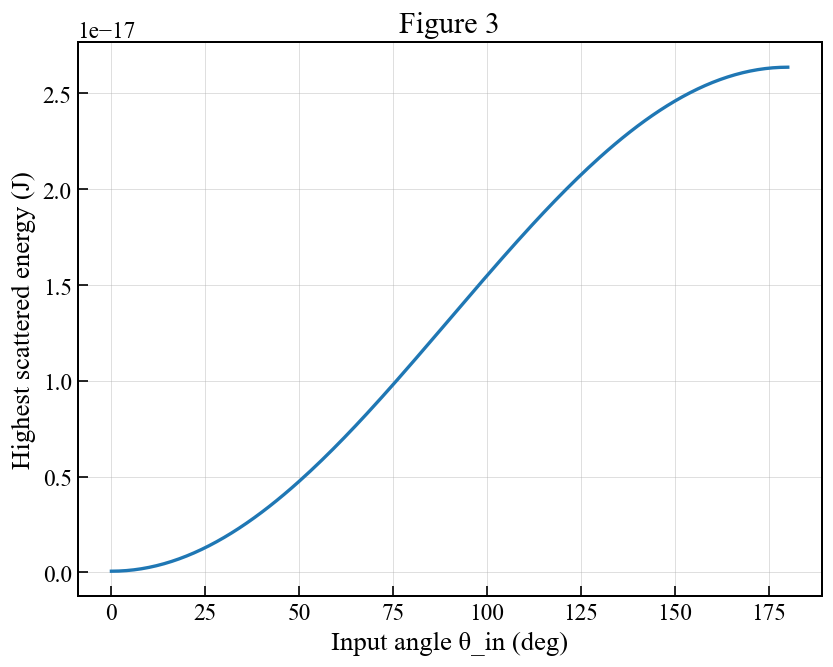

In [68]:
theta_in_vals = np.linspace(0,180,181)
gamma_val = 10
nu_in = 1e14

eps_out_list = []
for th in theta_in_vals:
    theta_s, gain = ics_gain_vs_theta_lab(gamma_val, nu_in, th)
    eps_out_list.append(max(gain)*h*nu_in)  # highest-energy scattered photon

plt.figure(figsize=(8,6))
plt.plot(theta_in_vals, eps_out_list, lw=2)
plt.xlabel("Input angle θ_in (deg)")
plt.ylabel("Highest scattered energy (J)")
plt.title("Figure 3")
plt.grid(True)
plt.show()


**Figure 4**: Mapping between the ERF scattering angle $\Theta'$ and the laboratory scattering angle $\theta_s$, with the color scale indicating the frequency gain $\tilde{\nu}/\nu$ for $\gamma=10$, $\nu_{\rm in}=10^{14}\,\mathrm{Hz}$, and $\theta_{\rm in}=0^\circ$. Forward scattering in the ERF ($\Theta'\approx0^\circ$) maps to small laboratory angles and is associated with the largest energy amplification, whereas backward ERF scattering appears at wide laboratory angles with comparatively low gain. This behavior arises from relativistic Doppler boosting combined with angular aberration.


Points: 300
Min gain: 0.0025125784721475946 Max gain: 0.9999999999999969


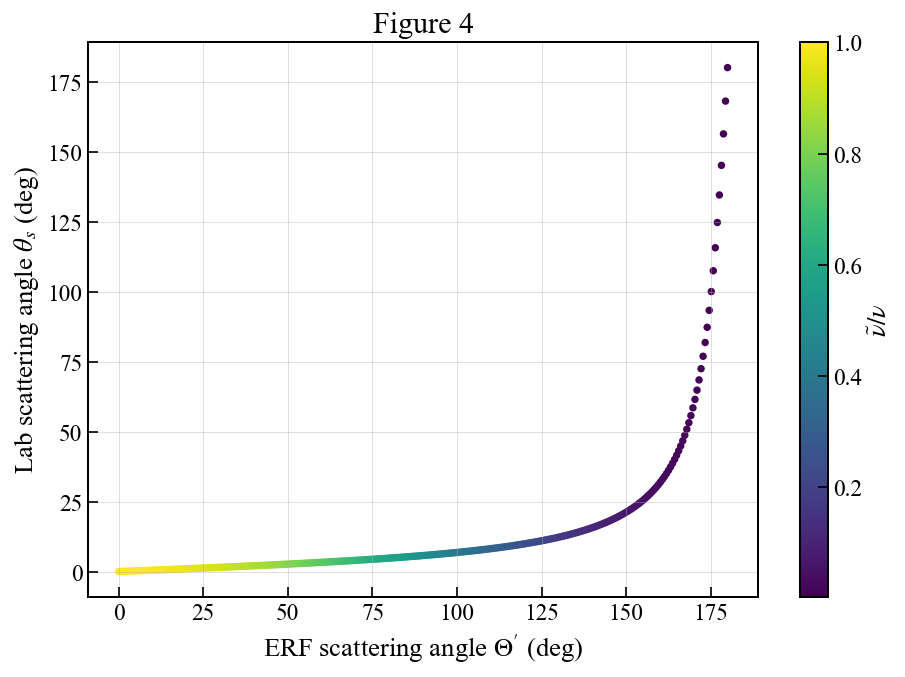

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
gamma_val = 10.0
nu_in = 1e14
theta_in = 0.0
beta = beta_from_gamma(gamma_val)

eps_lab = h * nu_in
cos_theta_lab = np.cos(np.radians(theta_in))

# 1) LAB → ERF
eps_prime = doppler_to_erf(eps_lab, cos_theta_lab, beta)
cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab, beta)

# 2) ERF scattering grid
Theta_prime = np.linspace(0, np.pi, 300)
cos_Theta_prime = np.cos(Theta_prime)

# 3) Outgoing direction in ERF
cos_theta_prime_out = cos_theta_out_erf(cos_theta_prime_in, cos_Theta_prime)

# 4) ERF scattered energy
eps_prime_out = epsilon_s_erf_kn(eps_prime, cos_Theta_prime)

# 5) ERF → LAB energy
eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
nu_out = eps_out / h
gain = nu_out / nu_in

# 6) LAB angles
cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
theta_s_lab = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1, 1)))

# ---- CLEAN NaNs or infs ----
mask = np.isfinite(theta_s_lab) & np.isfinite(gain)
Theta_prime_clean = Theta_prime[mask]
theta_s_lab_clean = theta_s_lab[mask]
gain_clean = gain[mask]

print("Points:", Theta_prime_clean.size)
print("Min gain:", gain_clean.min(), "Max gain:", gain_clean.max())

# ---- PLOT ----
plt.figure(figsize=(9,6))
sc = plt.scatter(Theta_prime_clean * 180/np.pi,
                 theta_s_lab_clean,
                 c=gain_clean,
                 cmap='viridis',
                 s=12)  # small clean dots

plt.colorbar(sc, label=r"$\tilde{\nu}/\nu$")
plt.xlabel(r"ERF scattering angle $\Theta'$ (deg)")
plt.ylabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.title("Figure 4")
plt.grid(True)
plt.show()



For a head-on lab photon that is back-scattered in the ERF ($\Theta'=\pi$), the maximum scattered photon energy in the lab is
$$
\epsilon_{\max}
= \frac{4\gamma^{2}\,\epsilon}{\,1+\dfrac{4\gamma\,\epsilon}{m_e c^{2}}\,}.
$$

**Limiting regimes**
- **Thomson limit** ($\gamma\epsilon \ll m_e c^{2}$): 
  $$
  \epsilon_{\max} \simeq 4\gamma^{2}\epsilon.
  $$
- **Klein–Nishina (KN) limit** ($\gamma\epsilon \gg m_e c^{2}$): 
  $$
  \epsilon_{\max} \simeq \gamma\,m_e c^{2}.
  $$

This result provides a useful upper bound on the photon energy attainable through inverse Compton scattering for a given electron Lorentz factor.


In [49]:

def epsilon_max_headon(gamma: float, epsilon_lab_J: float) -> float:
    # eps_max = 4 * gamma^2 * eps / (1 + 4 * gamma * eps / (m_e c^2))
    return (4.0 * gamma**2 * epsilon_lab_J) / (1.0 + 4.0 * gamma * epsilon_lab_J / me_c2)

# Tiny check
eps0 = h * 1e14
epsilon_max_headon(10.0, eps0)


2.6503422599407977e-17

**Interactive 1**: This interactive plot shows the inverse-Compton frequency gain $(\tilde{\nu}/\nu)$ versus the laboratory scattering angle $(\theta_s)$. Sliders control the electron Lorentz factor $(\gamma)$, the incident photon frequency $(\nu_{\rm in})$, and the incident angle $(\theta_{\rm in})$. The “Regime” toggle switches between the full Klein–Nishina kinematics and the Thomson approximation. Use it to visualize how head-on encounters and higher $(\gamma)$ shift the gain curve and sharpen the forward beaming.

**Controls.**
- **$\gamma$ (Lorentz factor):** sets electron speed. Larger $\gamma$ ⇒ stronger forward beaming and higher gains near $\theta_s \approx 0^\circ$.
- **$\nu_{\rm in}$ (Hz):** incident photon frequency. Higher $\nu_{\rm in}$ can push you toward the KN regime (suppression at large angles).
- **$\theta_{\rm in}$ (deg):** incident photon direction in the lab, measured from the electron’s $+z$ direction. Head-on ($\theta_{\rm in}\!\approx\!180^\circ$) gives largest boosts.
- **Regime (Thomson / KN):** chooses whether the ERF energy shift is elastic (Thomson) or uses the full Klein–Nishina expression (includes recoil).
- **Resolution:** number of ERF angles $\Theta'$ sampled between $0$ and $\pi$. Higher values give smoother curves but are slower.

**How to read the plot.**
- The **peak near $\theta_s\!\approx\!0^\circ$** shows forward beaming; its height grows with $\gamma$.
- The **fall-off with angle** reflects relativistic aberration and (if KN is on) recoil losses.
- Switching to **Thomson** should increase the high-angle gain relative to **KN**, where recoil suppresses energy at large $\Theta'$.

**Typical experiments to try.**
- Fix $\nu_{\rm in}$, vary $\gamma$: watch the curve sharpen and rise near small angles.
- Fix $\gamma$, increase $\nu_{\rm in}$: see when KN suppression becomes noticeable (curve lowers at larger angles).
- Change $\theta_{\rm in}$: head-on incidence ($\sim\!180^\circ$) maximizes boosts; co-moving ($\sim\!0^\circ$) minimizes them.

**Numerical tips.**
- If the plot appears empty, lower resolution or check that parameters are physical (e.g., $\gamma \ge 1$).  
- If you see gaps, it’s typically from edge-case divisions in aberration; a small reduction in resolution or avoiding exactly $\Theta' = \pi$ can help.


In [77]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    gamma_slider = widgets.FloatLogSlider(value=10.0, base=10, min=0, max=3, step=0.01,
                                          description="gamma", readout_format=".2f")
    nu_slider = widgets.FloatLogSlider(value=1e14, base=10, min=8, max=22, step=0.01,
                                       description="nu_in [Hz]", readout_format=".2e")
    theta_in_slider = widgets.FloatSlider(value=0.0, min=0.0, max=180.0, step=1.0,
                                          description="theta_in [deg]")
    regime_toggle = widgets.ToggleButtons(options=[("Klein–Nishina", True), ("Thomson", False)],
                                          description="Regime")

    out = widgets.Output()

    def redraw(_=None):
        with out:
            clear_output(wait=True)
            theta_s, gain = ics_gain_vs_theta_lab(
                gamma=gamma_slider.value,
                nu_in_hz=nu_slider.value,
                theta_in_deg=theta_in_slider.value,
                use_klein_nishina=regime_toggle.value,
                n_angles=361
            )
            plt.figure()
            plt.plot(theta_s, gain, lw=2)
            plt.xlabel(r"Lab scattering angle $\theta _s$ (deg)")
            plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")

            plt.title("Inverse Compton (interactive)")
            plt.grid(True)
            plt.show()

    for w in (gamma_slider, nu_slider, theta_in_slider, regime_toggle):
        w.observe(redraw, names="value")

    ui = widgets.VBox([gamma_slider, nu_slider, theta_in_slider, regime_toggle, out])
    display(ui)
    redraw()

except Exception as e:
    print("ipywidgets not available:", e)
    print("You can still use ics_gain_vs_theta_lab(...) and plot manually.")


**Figure 5:** This cell constructs a schematic broadband spectrum combining thermal free–free emission and saturated inverse Compton scattering. At low and intermediate frequencies, the spectrum is modeled as a modified blackbody produced by free–free emission and absorption. At high frequencies, the spectrum transitions smoothly to a Wien tail, representing saturated Comptonization by a hot electron population. The matching at $\nu_{\rm IC}$ ensures continuity of the spectrum, while the vertical markers indicate the free–free optical depth unity frequency and the onset of the Comptonized regime.



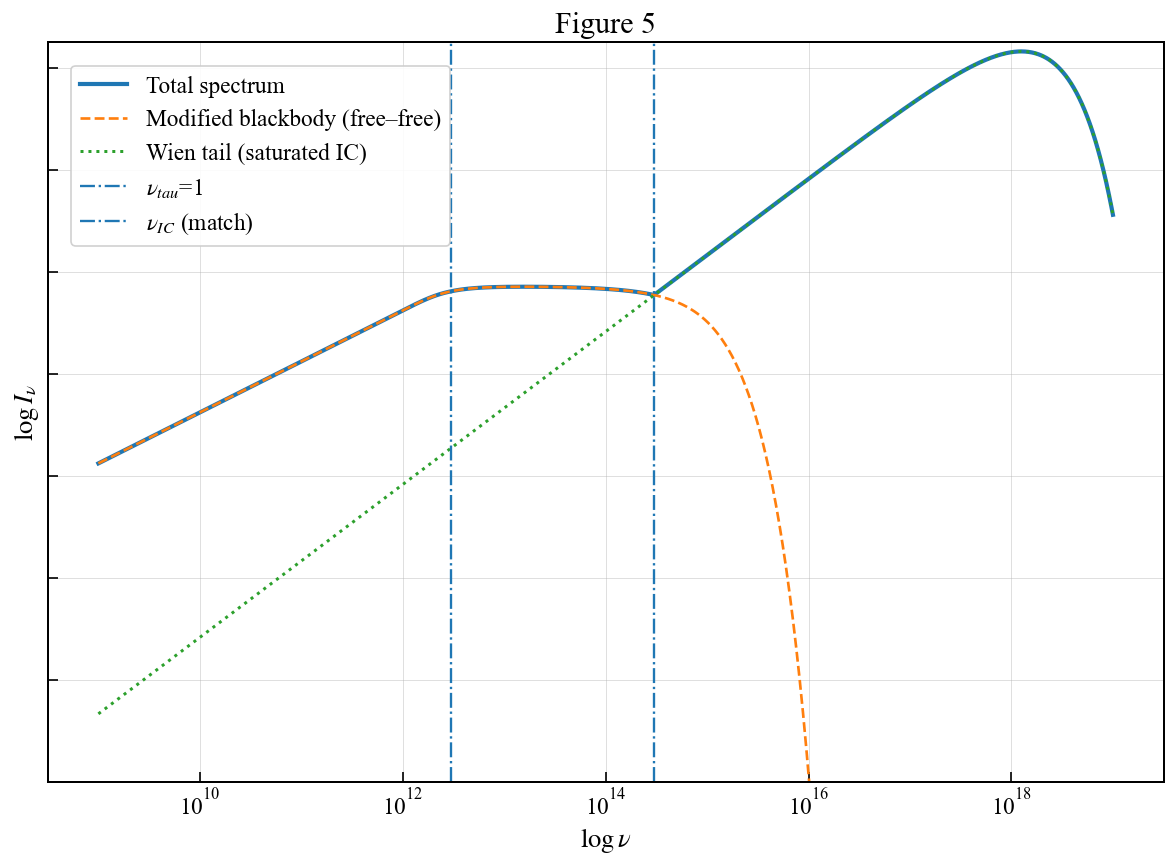

In [72]:
# Corrected spectrum plot (no markdown issues, clean code)

import numpy as np
import matplotlib.pyplot as plt

# --- Physical constants (SI) ---
h  = 6.62607015e-34
kB = 1.380649e-23
c  = 2.99792458e8

def Bnu(nu, T):
    """Planck function B_nu(T) [W m^-2 Hz^-1 sr^-1]."""
    x = h * nu / (kB * T)
    with np.errstate(over='ignore', under='ignore', invalid='ignore'):
        ex = np.exp(np.clip(x, 0, 700))
        return (2*h*nu**3)/(c**2) / (ex - 1.0)

def I_ff_modified(nu, T, nu_tau1):
    """Modified blackbody with free–free absorption: tau_ff = (nu/nu_tau1)^(-2)."""
    tau = (nu/nu_tau1)**(-2.0)
    return Bnu(nu, T) * (1.0 - np.exp(-tau))

def wien_matched(nu, T_e, nu_match, I_match):
    """Wien tail A * nu^3 * exp(-h nu / (k T_e)), normalized at nu_match."""
    Wm = (nu_match**3) * np.exp(-h*nu_match/(kB*T_e))
    A  = I_match / Wm if Wm > 0 else 0.0
    return A * (nu**3) * np.exp(-h*nu/(kB*T_e))

# --- Model parameters ---
T_rad  = 1.0e4        # thermal medium temperature (free–free/blackbody)
nu_tau1 = 3e12        # free–free optical depth unity
T_e    = 2.0e7        # electron temperature for Wien tail
nu_IC  = 3e14         # matching point to Comptonized Wien tail

# Frequency grid
nu = np.logspace(9, 19, 1500)

# Compute components
I_mid = I_ff_modified(nu, T_rad, nu_tau1)
I_match = np.interp(nu_IC, nu, I_mid)
I_wien = wien_matched(nu, T_e, nu_IC, I_match)

# Combine
I_tot = np.where(nu <= nu_IC, I_mid, I_wien)

# Plot
plt.figure(figsize=(12, 8))
plt.loglog(nu, I_tot, linewidth=2.5, label="Total spectrum")
plt.loglog(nu, I_mid, linestyle="--", linewidth=1.6, label="Modified blackbody (free–free)")
plt.loglog(nu, I_wien, linestyle=":", linewidth=1.8, label="Wien tail (saturated IC)")

plt.axvline(nu_tau1, linestyle="-.", linewidth=1.4, label=r"$\nu_{tau}$=1")
plt.axvline(nu_IC,   linestyle="-.", linewidth=1.4, label=r"$\nu_{IC}$ (match)")

plt.xlabel(r"$\log \nu$")
plt.ylabel(r"$\log I_{\nu}$")
plt.legend()
plt.ylim(1e-30,1e-1)
plt.title('Figure 5')
plt.gca().tick_params(axis='y', labelleft=False)

plt.show()


**Interactive 2 — Free–free → Comptonized Wien spectrum (normalized)**

This interactive cell explores a schematic broadband spectrum transitioning from a free–free–modified blackbody to a Comptonized Wien bump. Vertical guide lines mark $ \nu_{\tau=1} $, $ \nu_{\rm IC}^{\rm start} $, and a proxy for the Wien peak
$$
\nu_{\rm peak} \simeq \frac{3 k_{\rm B} T_e}{h}.
$$

**Controls.**
- **$T_{\rm rad}$ (K):** thermal radiation temperature setting the blackbody baseline. Increasing $T_{\rm rad}$ raises the modified blackbody level and shifts its characteristic frequencies upward.
- **$\nu_{\tau=1}$ (Hz):** frequency at which the free–free optical depth equals unity. Larger $\nu_{\tau=1}$ moves the optically thick–to–thin turnover to higher frequencies.
- **$T_e$ (K):** electron temperature governing the Comptonized Wien tail. Higher $T_e$ shifts the high-frequency cutoff to larger $\nu$ and broadens the Wien bump.
- **$\nu_{\rm IC}^{\rm start}$ (Hz):** onset frequency where the spectrum transitions from the modified blackbody to the Comptonized component. Changing this parameter redistributes power between the mid- and high-frequency regimes.
- **bump slope:** heuristic parameter controlling how rapidly the spectrum rises before the Wien cutoff.
- **show components:** overlays the individual spectral components and their sum.
- **hide y labels:** suppresses y-axis tick labels for cleaner visualization.

**How to read the plot.**
- **Low frequencies (optically thick):** the spectrum approaches the blackbody limit,
  $$
  I_\nu \rightarrow B_\nu(T_{\rm rad}),
  $$
  corresponding to the Rayleigh–Jeans behavior $I_\nu \propto \nu^2$.
- **Intermediate region:** near $\nu_{\tau=1}$, free–free absorption weakens. Since $\tau_{\rm ff} \propto \nu^{-2}$, a nearly flat plateau $I_\nu \propto \nu^0$ can appear.
- **High frequencies:** beyond $\nu_{\rm IC}^{\rm start}$, saturated Comptonization produces a Wien-like spectrum,
  $$
  I_\nu \propto \nu^3 \exp\!\left(-\frac{h\nu}{k_{\rm B} T_e}\right),
  $$
  with a peak near $\nu_{\rm peak}$.

**Experiments to try.**
- Fix $\nu_{\rm IC}^{\rm start}$ and increase $T_e$: the Wien peak shifts to higher frequencies.
- Fix $T_e$ and vary $\nu_{\tau=1}$: the turnover and plateau move accordingly.
- Increase $\nu_{\rm IC}^{\rm start}$: the transition to the Comptonized regime occurs at higher frequency.
- Toggle **show components** to inspect how the total spectrum is assembled.

**Notes.**
- This is a schematic model intended to reproduce the qualitative behavior shown in Rybicki & Lightman (Fig. 7.4).
- Adjust the y-axis limits if the plotted spectrum appears visually compressed.



In [70]:
# --- Interactive RL-7.4 style spectrum explorer ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider, FloatSlider, Checkbox, fixed

# --- physics helpers (redeclare here for a self-contained cell) ---
h  = 6.62607015e-34
kB = 1.380649e-23
c  = 2.99792458e8

def Bnu(nu, T):
    x = h*nu/(kB*T)
    with np.errstate(over='ignore', under='ignore', invalid='ignore'):
        ex = np.exp(np.clip(x, 0, 700))
        return (2*h*nu**3)/(c**2) / (ex - 1.0)

def I_freefree_modified(nu, T, nu_tau1):
    tau = (nu/nu_tau1)**(-2.0)
    return Bnu(nu, T) * (1.0 - np.exp(-tau))

def I_wien_bump(nu, T_e, nu_match, I_match, slope_up=1.0):
    x = h*nu/(kB*T_e)
    wien = (nu**3) * np.exp(-x)
    wien_match = (nu_match**3) * np.exp(-h*nu_match/(kB*T_e))
    rise = (nu/nu_match)**slope_up
    A = I_match / wien_match if wien_match > 0 else 0.0
    return A * wien * rise

def plot_spectrum_interactive(T_rad, nu_tau1, T_e, nu_IC_start, slope_up,
                              show_components=True, hide_ylabels=False):
    # frequency grid (covers radio → gamma)
    nu = np.logspace(9, 20, 2000)

    I_ff    = I_freefree_modified(nu, T_rad, nu_tau1)
    I_match = np.interp(nu_IC_start, nu, I_ff)
    I_ic    = I_wien_bump(nu, T_e, nu_IC_start, I_match, slope_up=slope_up)

    I_tot = np.where(nu < nu_IC_start, I_ff, I_ic)
    I_tot_norm = I_tot / np.max(I_tot)

    # landmark ~ Wien peak
    nu_peak_est = 3.0 * kB * T_e / h

    plt.figure(figsize=(12, 8))
    plt.loglog(nu, I_tot_norm, linewidth=3.0, label="Total")

    if show_components:
        plt.loglog(nu, I_ff/np.max(I_tot), "--", linewidth=1.8, label="Free–free modified BB")
        plt.loglog(nu, I_ic/np.max(I_tot), ":",  linewidth=2.0, label="Comptonized Wien bump")

    # guides
    plt.axvline(nu_tau1,     linestyle="-.", linewidth=1.3, color="gray")
    plt.axvline(nu_IC_start, linestyle="-.", linewidth=1.3, color="gray")
    plt.axvline(nu_peak_est, linestyle="-.", linewidth=1.3, color="gray")

    # labels
    plt.xlabel("log ν (Hz)")
    plt.ylabel("log $I_\\nu$ (arb. units)")
    plt.xscale("log"); plt.yscale("log")
    plt.grid(True, which="both", alpha=0.35)
    if show_components:
        plt.legend(loc="upper left", fontsize=12)

    # optional: hide y tick labels
    if hide_ylabels:
        plt.gca().tick_params(axis='y', labelleft=False)

    plt.ylim(1e-30,10)

    plt.tight_layout()
    plt.show()

# --- Widgets ---
interact(
    plot_spectrum_interactive,
    T_rad=FloatLogSlider(value=1.2e4, base=10, min=3, max=5, step=0.01, description="T_rad (K)"),
    nu_tau1=FloatLogSlider(value=6e11, base=10, min=9, max=15, step=0.01, description="ν_τ=1 (Hz)"),
    T_e=FloatLogSlider(value=7e7, base=10, min=6, max=9, step=0.01, description="T_e (K)"),
    nu_IC_start=FloatLogSlider(value=3e13, base=10, min=10, max=18, step=0.01, description="ν_IC start (Hz)"),
    slope_up=FloatSlider(value=0.9, min=0.0, max=2.0, step=0.05, description="bump slope"),
    show_components=Checkbox(value=True, description="show components"),
    hide_ylabels=Checkbox(value=False, description="hide y labels")
);


interactive(children=(FloatLogSlider(value=12000.0, description='T_rad (K)', max=5.0, min=3.0, step=0.01), Flo…


### Isotropic Soft-Photon Field (Monte Carlo)

This section implements a Monte Carlo realization of inverse Compton scattering for an isotropic soft-photon field in the laboratory frame. Monoenergetic photons are drawn with isotropic incidence angles and are scattered once by a monoenergetic electron with Lorentz factor $\gamma$.

The ERF scattering angle $\Theta'$ is sampled according to the Thomson angular distribution, proportional to $1+\cos^2\Theta'$, while the scattered photon energy is computed using either the Thomson approximation or the full Klein–Nishina expression. After scattering, photon energies and directions are transformed back to the laboratory frame.

The resulting distributions illustrate how relativistic aberration and Doppler boosting shape the angular and energy output of inverse Compton scattering, even when the incident photon field is isotropic.


In [78]:
import numpy as np

def sample_thomson_cosTheta_prime(n: int, rng=None) -> np.ndarray:
    """Sample cos(Theta') in ERF with Thomson angular weight ∝ (1+cos^2 Theta')."""
    if rng is None:
        rng = np.random.default_rng()
    out = []
    while len(out) < n:
        u = rng.uniform(-1.0, 1.0, size=n)  # proposal for cos(Theta')
        y = rng.uniform(0.0, 1.0, size=n)
        w = 0.5 * (1.0 + u*u)               # normalized to max 1 at |u|=1
        accept = y < w
        out.extend(u[accept].tolist())
    return np.array(out[:n])

def ics_isotropic_soft_photons(gamma: float = 10.0, nu_in_hz: float = 1e12,
                               n_phot: int = 5000, use_klein_nishina: bool = True, seed: int = 123):
    """Monoenergetic photons isotropic in LAB → single scatter → LAB outputs (theta_s, gain, energies)."""
    rng = np.random.default_rng(seed)
    beta = beta_from_gamma(gamma)
    eps_lab = h * nu_in_hz

    # Isotropic incidence in LAB
    cos_theta_lab_in = rng.uniform(-1.0, 1.0, size=n_phot)

    # LAB → ERF
    eps_prime_in = doppler_to_erf(eps_lab, cos_theta_lab_in, beta)
    cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab_in, beta)

    # ERF scatter angle (Thomson angular weighting)
    cos_Theta_prime = sample_thomson_cosTheta_prime(n_phot, rng=rng)

    # ERF outgoing angle relative to +z
    theta_prime_in = np.arccos(np.clip(cos_theta_prime_in, -1, 1))
    sin_theta_prime_in = np.sin(theta_prime_in)
    sin_Theta = np.sqrt(1.0 - cos_Theta_prime**2)
    cos_theta_prime_out = cos_theta_prime_in * cos_Theta_prime + sin_theta_prime_in * sin_Theta

    # ERF scattered energy
    if use_klein_nishina:
        eps_prime_out = epsilon_s_erf_kn(eps_prime_in, cos_Theta_prime)
    else:
        eps_prime_out = eps_prime_in  # Thomson: elastic in ERF

    # ERF → LAB
    eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
    nu_out = eps_out / h

    # LAB scattering angle
    cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
    theta_lab_out = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1.0, 1.0)))

    gain = nu_out / nu_in_hz
    return theta_lab_out, gain, eps_out, eps_lab


samples: 8000  |  θ valid: 8000  |  gain valid: 8000


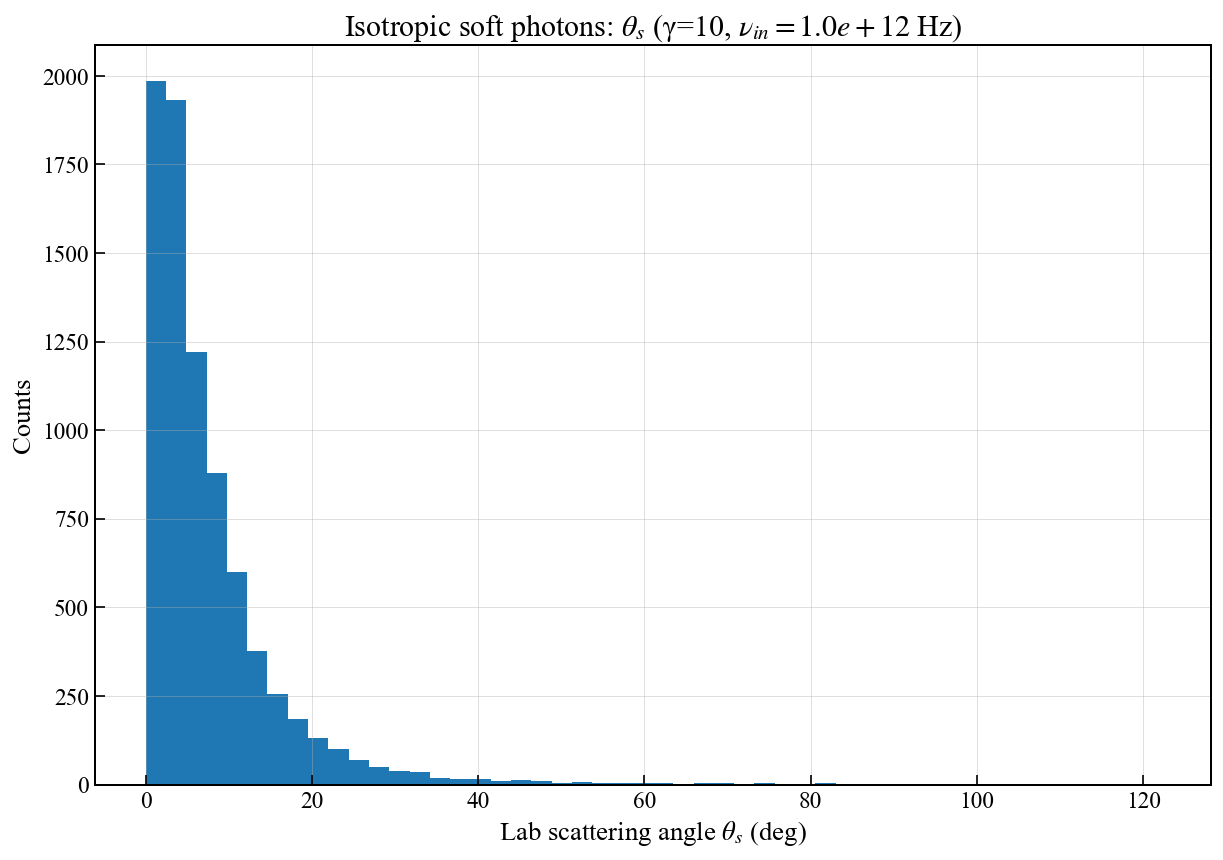

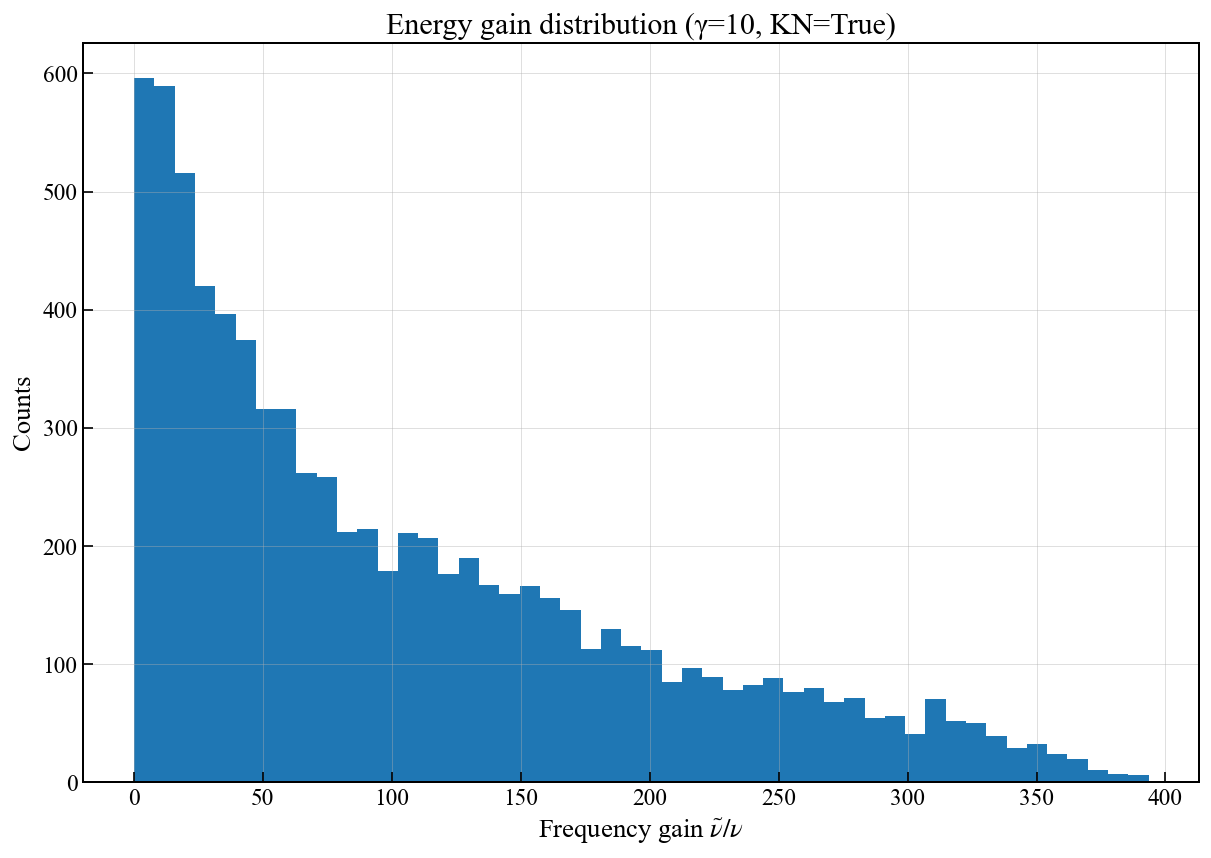

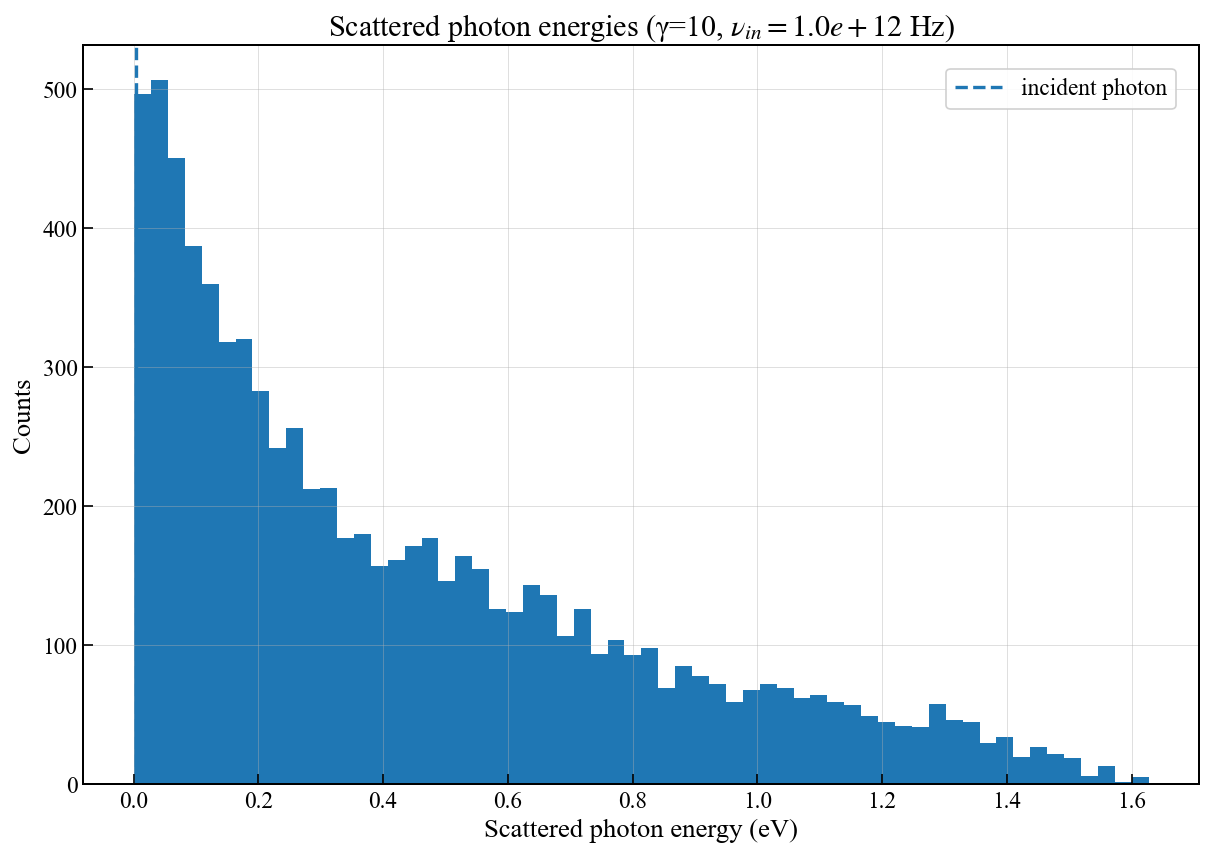

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# 0) Constants (ensure eV exists)
eV = 1.602176634e-19   # J per eV

# 1) Parameters (tweak if you like)
gamma_plot = 10.0
nu_in_plot = 1e12
n_samples  = 8000
use_kn     = True
rng_seed   = 42

# 2) Required helpers (only if not already defined)
def sample_thomson_cosTheta_prime(n: int, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng()
    out = []
    while len(out) < n:
        u = rng.uniform(-1.0, 1.0, size=n)  # proposal cos(Theta')
        y = rng.uniform(0.0, 1.0, size=n)
        w = 0.5 * (1.0 + u*u)                # normalized to max 1
        accept = y < w
        out.extend(u[accept].tolist())
    return np.array(out[:n])

def doppler_to_lab(epsilon_erf_J, cos_theta_prime_out, beta: float):
    g = gamma_from_beta(beta)
    eps  = np.asarray(epsilon_erf_J, dtype=float)
    cosp = np.clip(np.asarray(cos_theta_prime_out, dtype=float), -1.0, 1.0)
    return g * eps * (1.0 + beta * cosp)

def aberration_erf_to_lab(cos_theta_prime_out, beta: float):
    cosp = np.clip(np.asarray(cos_theta_prime_out, dtype=float), -1.0, 1.0)
    num = cosp + beta
    den = 1.0 + beta * cosp
    return np.clip(num/den, -1.0, 1.0)

def ics_isotropic_soft_photons(gamma: float, nu_in_hz: float, n_phot: int,
                               use_klein_nishina: bool=True, seed: int=123):
    rng = np.random.default_rng(seed)
    beta = beta_from_gamma(gamma)
    eps_lab = h * nu_in_hz

    # Isotropic incidence in LAB
    cos_theta_lab_in = rng.uniform(-1.0, 1.0, size=n_phot)

    # LAB -> ERF
    eps_prime_in = doppler_to_erf(eps_lab, cos_theta_lab_in, beta)
    cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab_in, beta)

    # ERF scatter angle (Thomson weight)
    cos_Theta_prime = sample_thomson_cosTheta_prime(n_phot, rng=rng)

    # ERF outgoing direction wrt +z
    theta_prime_in = np.arccos(np.clip(cos_theta_prime_in, -1, 1))
    sin_theta_prime_in = np.sin(theta_prime_in)
    sin_Theta = np.sqrt(1.0 - cos_Theta_prime**2)
    cos_theta_prime_out = (cos_theta_prime_in * cos_Theta_prime
                           + sin_theta_prime_in * sin_Theta)

    # ERF scattered energy
    if use_klein_nishina:
        eps_prime_out = epsilon_s_erf_kn(eps_prime_in, cos_Theta_prime)
    else:
        eps_prime_out = eps_prime_in  # Thomson: elastic in ERF

    # ERF -> LAB
    eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
    nu_out  = eps_out / h
    gain    = nu_out / nu_in_hz

    # LAB angle
    cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
    theta_lab_out = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1.0, 1.0)))

    return theta_lab_out, gain, eps_out, eps_lab

# 3) Generate samples
theta_samp, gain_samp, eps_out_samp, eps_in_J = ics_isotropic_soft_photons(
    gamma=gamma_plot, nu_in_hz=nu_in_plot, n_phot=n_samples,
    use_klein_nishina=use_kn, seed=rng_seed
)

# 4) Sanity print
print(f"samples: {len(theta_samp)}  |  θ valid: {np.isfinite(theta_samp).sum()}  |  gain valid: {np.isfinite(gain_samp).sum()}")

# 5) Plot 6 — Histogram of θ_s
plt.figure(figsize=(12,8))
plt.hist(theta_samp[np.isfinite(theta_samp)], bins=50)
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel("Counts")
plt.title(rf"Isotropic soft photons: $\theta_s$ (γ={gamma_plot:.0f}, $\nu_{{in}}={nu_in_plot:.1e}$ Hz)")
plt.grid(True)
plt.show()

# 6) Plot 7 — Histogram of energy gain
plt.figure(figsize=(12,8))
plt.hist(gain_samp[np.isfinite(gain_samp)], bins=50)
plt.xlabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.ylabel("Counts")
plt.title(rf"Energy gain distribution (γ={gamma_plot:.0f}, KN={use_kn})")
plt.grid(True)
plt.show()

# 8) Energy plot — scattered photon energies (eV); with incident & electron kinetic for context
eps_out_eV = eps_out_samp / eV
eps_in_eV  = eps_in_J / eV
E_e_kin_eV = ((gamma_plot - 1.0) * me * c**2) / eV

plt.figure(figsize=(12,8))
plt.hist(eps_out_eV[np.isfinite(eps_out_eV)], bins=60)
plt.axvline(eps_in_eV, linestyle="--", linewidth=2, label="incident photon")
# plt.axvline(E_e_kin_eV, linestyle=":", linewidth=2, label=r"electron kinetic $(\gamma-1)m_ec^2$")
plt.xlabel("Scattered photon energy (eV)")
plt.ylabel("Counts")
plt.title(rf"Scattered photon energies (γ={gamma_plot:.0f}, $\nu_{{in}}={nu_in_plot:.1e}$ Hz)")
plt.legend()
plt.grid(True)
plt.show()


In [83]:
eps_clean = eps_out_eV[np.isfinite(eps_out_eV)]



Increasing $\gamma$ or $\nu_{\rm in}$ shifts the scattered photon energy distribution to higher values, while Klein–Nishina effects suppress the high-energy tail at large energies.


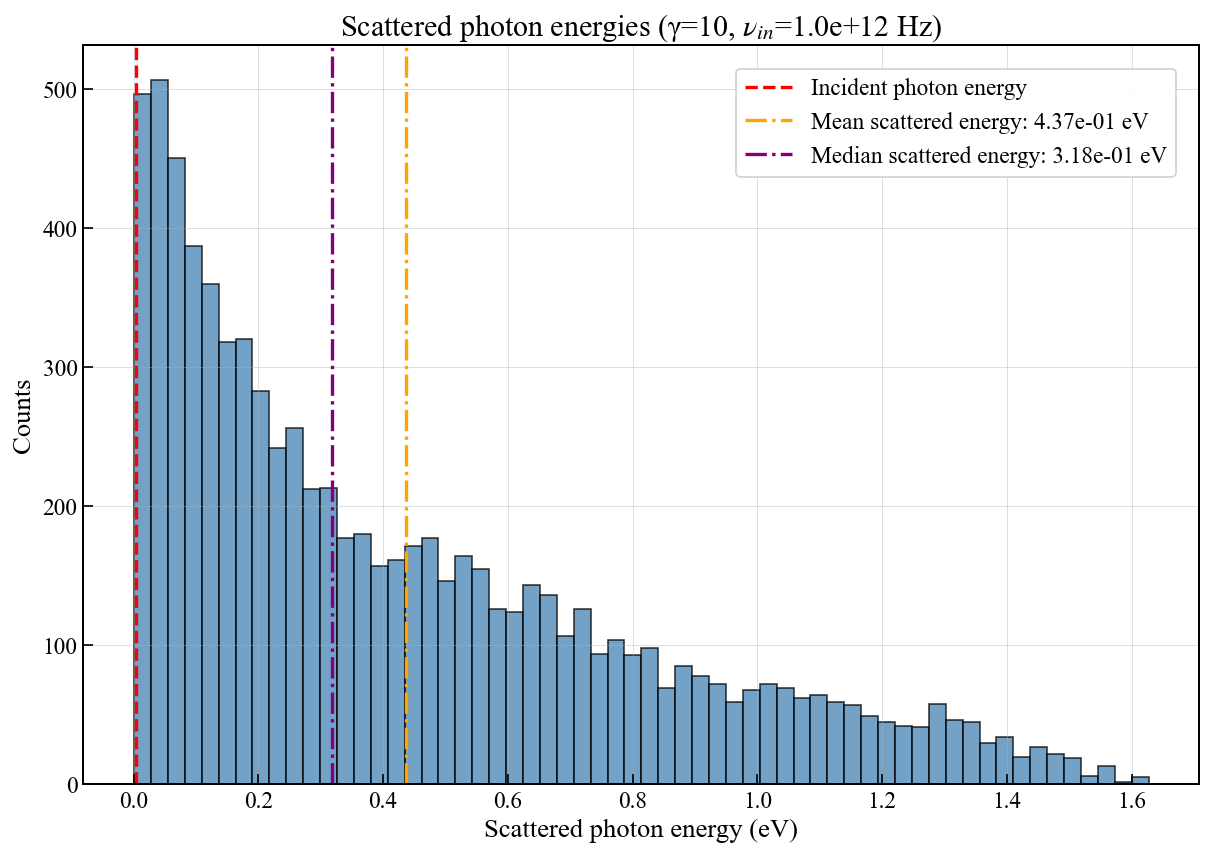

In [84]:
# --- Compute reference energies if not already defined ---
eps_in_eV = eps_in_J / eV                         # incident photon energy (eV)
E_e_kin_eV = ((gamma_plot - 1.0) * me * c**2) / eV   # electron kinetic energy (eV)

# Mean and median scattered photon energy
mean_e = np.nanmean(eps_clean)
median_e = np.nanmedian(eps_clean)

# --- Plot ---
plt.figure(figsize=(12,8))
plt.hist(eps_clean, bins=60, alpha=0.75, color="steelblue", edgecolor="black")

# Vertical reference lines
plt.axvline(eps_in_eV, color="red", linestyle="--", linewidth=2,
            label="Incident photon energy")

# plt.axvline(E_e_kin_eV, color="green", linestyle=":", linewidth=2.5,
#             label=r"Electron kinetic energy $(\gamma-1)m_ec^2$")

plt.axvline(mean_e, color="orange", linestyle="-.", linewidth=2,
            label=f"Mean scattered energy: {mean_e:.2e} eV")

plt.axvline(median_e, color="purple", linestyle="dashdot", linewidth=2,
            label=f"Median scattered energy: {median_e:.2e} eV")

# Labels, title, etc.
plt.xlabel("Scattered photon energy (eV)")
plt.ylabel("Counts")
plt.title(rf"Scattered photon energies (γ={gamma_plot:.0f}, $\nu_{{in}}$={nu_in_plot:.1e} Hz)")

plt.legend()
plt.grid(True)
plt.show()
